In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import os
import math
import matplotlib.pyplot as plt
import numpy as np

from Load_Data import load_data

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
device = torch.device(device)
print(f"Using {device} device")

Using mps device


# Load Data

In [56]:
def get_data_loaders(batch_size=64, faste_files_to_load=37, normalize=False):
    Data = load_data(data_dir=os.path.join(os.getcwd(), 'Data', 'Parsed_Data'), 
                     train_val_data_to_load=1000, 
                     test_data_to_load=10,
                     faste_files_to_load=faste_files_to_load,
                     normalize=normalize)
    
    training_dataset, validation_dataset, testing_dataset = Data

    train_loader = DataLoader(dataset=training_dataset,
                              batch_size=batch_size,shuffle=True)
    val_loader = DataLoader(dataset=validation_dataset,
                              batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(dataset=testing_dataset,
                              batch_size=batch_size,shuffle=True)
    return train_loader, val_loader, test_loader

faste_files_to_load = 3
normalize = True
train_loader, val_loader, test_loader = get_data_loaders(faste_files_to_load=faste_files_to_load, normalize=normalize)

Loading sequences from sequences.fasta
Loading coverage from SRX391990.faste
Loading coverage from SRX9770779.faste
Loading coverage from SRX9770784.faste
Done Loading Data


# Build Model

In [ ]:
class DnaCnn(nn.Module):
    def __init__(self, num_kernels=[512, 256, 128], kernel_size=[1028,256,128],
                 dropout=0):
        super(DnaCnn, self).__init__()
        self.input_channels=4
        self.num_kernels=num_kernels
        self.kernel_size=kernel_size
        self.dropout=dropout
        self.conv_block = nn.Sequential(
            # first layer
            nn.Conv1d(in_channels=self.input_channels,
                      out_channels=num_kernels[0],
                      kernel_size=kernel_size[0]),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.MaxPool1d(kernel_size=2),
        )
        # second layer
        # self.conv_block.append(nn.Sequential(
        #     nn.Conv1d(in_channels=self.num_kernels[0],
        #               out_channels=num_kernels[1],
        #               kernel_size=kernel_size[1]),
        #     nn.ReLU(),
        #     nn.MaxPool1d(kernel_size=2),
        #     nn.Dropout(p=self.dropout),            
        # ))
        # Add a third convolutional layer
        # self.conv_block.append(nn.Sequential(
        #     # second layer
        #     nn.Conv1d(in_channels=self.num_kernels[1],
        #               out_channels=num_kernels[2],
        #               kernel_size=kernel_size[2]),
        #     nn.ReLU(),
        #     nn.MaxPool1d(kernel_size=2),
        #     nn.Dropout(p=self.dropout),            
        # ))
        self.regression_block = nn.Sequential(
            nn.Linear(num_kernels[0], 37),
            nn.ReLU(),  # ReLU ensures positive outputs
            # nn.LogSoftmax(dim=1)  # Apply log softmax if necessary for your task
        )  

    def forward(self, x):
        x = self.conv_block(x)
        x,_ = torch.max(x, dim=2)        
        x = self.regression_block(x)
        return x

In [41]:
class LocalDnaCnn(nn.Module):
    def __init__(self, num_kernels=[30, 30, 30, 30], kernel_size=[50,50,50,50],
                 dropout=0):
        super(LocalDnaCnn, self).__init__()
        self.input_channels=4
        self.num_kernels=num_kernels
        self.kernel_size=kernel_size
        self.dropout=dropout
        self.conv_block = nn.Sequential(
            # first layer
            nn.Conv1d(in_channels=self.input_channels,
                      out_channels=num_kernels[0],
                      kernel_size=kernel_size[0]),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.MaxPool1d(kernel_size=2),
        )
        # second layer
        self.conv_block.append(nn.Sequential(
            nn.Conv1d(in_channels=self.num_kernels[0],
                      out_channels=num_kernels[1],
                      kernel_size=kernel_size[1]),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=self.dropout),            
        ))
        # Add a third convolutional layer
        self.conv_block.append(nn.Sequential(
            # second layer
            nn.Conv1d(in_channels=self.num_kernels[1],
                      out_channels=num_kernels[2],
                      kernel_size=kernel_size[2]),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=self.dropout),            
        ))
        # Add a fourth convolutional layer
        self.conv_block.append(nn.Sequential(
            nn.Conv1d(in_channels=self.num_kernels[2],
                      out_channels=num_kernels[3],
                      kernel_size=kernel_size[3]),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=self.dropout),            
        ))
        self.regression_block = nn.Sequential(
            nn.Linear(num_kernels[3], num_kernels[3]),
            nn.Linear(num_kernels[3], faste_files_to_load),
            #nn.ReLU(),  # ReLU ensures positive outputs
        )  

    def forward(self, x):
        x = self.conv_block(x)
        x,_ = torch.max(x, dim=2)        
        x = self.regression_block(x)
        return x

# Train Model

### Training functions

In [10]:
def train_epoch(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader)
    num_batches = len(dataloader)
    total_loss = 0
    # set the model to training mode - important when you have 
    # batch normalization and dropout layers
    model.train()
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # Compute prediction and loss
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        # backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0 :
        print(f"training loss: {total_loss/num_batches:>7f}")
    return total_loss / num_batches

def validation(dataloader, model, loss_fn, epoch):
    # set the model to evaluation mode 
    model.eval()
    # size of dataset
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss, correct = 0, 0
    # Evaluating the model with torch.no_grad() ensures that no gradients 
    # are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage 
    # for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            validation_loss += loss_fn(y_pred, y).item()
    validation_loss /= num_batches
    if epoch%10 == 0 :
        print(f"Validation Loss: {validation_loss:>8f} \n")
    return validation_loss

def train_model(train_loader, val_loader, model, optimizer, epochs, patience=10):
    loss_fn = nn.PoissonNLLLoss(log_input=True, full=True)
    p = patience

    train_loss = []
    validation_loss = []
    best_loss = math.inf
    for t in range(epochs):
        if t % 10 == 0 :
            print(f"Epoch {t}\n-------------------------------")
        loss = train_epoch(train_loader, model, loss_fn, optimizer, t)
        train_loss.append(loss)
        loss = validation(val_loader, model, loss_fn, t)
        validation_loss.append(loss)
    
        if loss < best_loss:
            best_loss = loss    
            p = patience
        else:
            p -= 1
            if p == 0:
                print("Early Stopping!")
                break    
    print("Done!")

    def plot_loss(train_loss, validation_loss):
        plt.figure(figsize=(4,3))
        plt.plot(np.arange(len(train_loss)), train_loss, label='Training')
        plt.plot(np.arange(len(validation_loss)), validation_loss, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    plot_loss(train_loss, validation_loss)


### Train

Epoch 0
-------------------------------
training loss: 0.497005
Validation Loss: 0.323879 

Epoch 10
-------------------------------
training loss: 0.248942
Validation Loss: 0.242122 

Epoch 20
-------------------------------
training loss: 0.247495
Validation Loss: 0.238897 

Epoch 30
-------------------------------
training loss: 0.247512
Validation Loss: 0.242020 

Early Stopping!
Done!


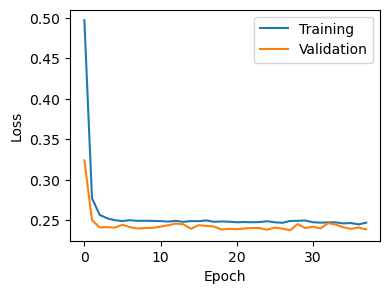

In [42]:
model = LocalDnaCnn().to(device)
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_model(train_loader, val_loader, model, optimizer, 50, 10)

### Save Model

In [ ]:
torch.save(model, "model.pth")

### Validate Model

In [ ]:
model = torch.load("model.pth", weights_only=False)
model.to(device)
model.eval()

In [47]:
X, y = next(iter(test_loader))
X = X.to(device)

y = y.to(device)
y_pred = torch.exp(model.forward(X).to(device))

print(y[0])
print(y_pred[0])

loss_fn = nn.PoissonNLLLoss(log_input=False, full=True)
print(loss_fn(y_pred, y))

tensor([0.0503, 0.0578, 0.0430], device='mps:0')
tensor([0.0832, 0.0768, 0.0397], device='mps:0', grad_fn=<SelectBackward0>)
tensor(0.2571, device='mps:0', grad_fn=<MeanBackward0>)


In [49]:
i = 2
print('Tissue: Predicted, True')
for s, (y_p, y_t) in enumerate(zip(y_pred[i], y[i])):
    print(f'{s}: {torch.exp(y_p):.1f}, {y_t:.1f}')

Tissue: Predicted, True
0: 1.1, 0.1
1: 1.1, 0.1
2: 1.0, 0.1


In [ ]:
Data = load_data(os.path.join(os.getcwd(), 'Data', 'Parsed_Data'), 
                 train_val_data_to_load=1, 
                 test_data_to_load=math.inf,
                 normalize=normalize,
                 faste_files_to_load=faste_files_to_load)

training_dataset, validation_dataset, testing_dataset = Data


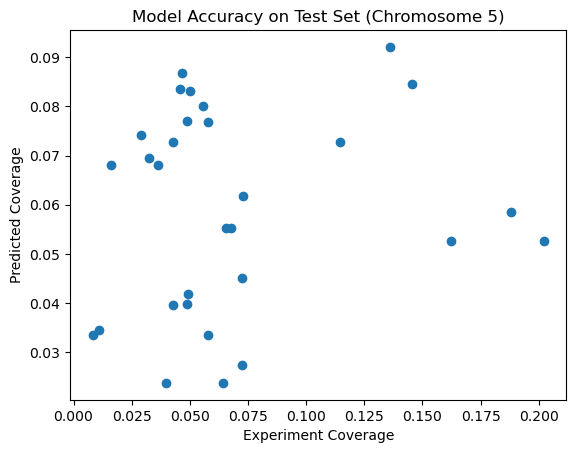

In [128]:
for _, (X, y) in enumerate(test_loader):
    X, y = X.to(device), y
    y_pred = torch.exp(model(X).to(device))

y = torch.flatten(y).cpu().numpy()
y_pred = torch.flatten(y_pred).cpu().detach().numpy()
pearson_r = np.corrcoef(y, y_pred)[0, 1]

plt.scatter(y, y_pred)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Test Set (Chromosome 5)")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b 
plt.show()

plt.title(f"Scatter Plot (Pearson Correlation = {correlation_coefficient:.2f})")

# Add the correlation coefficient to the plot
plt.text(0.1, 0.9, f"r = {correlation_coefficient:.2f}", transform=plt.gca().transAxes)

# Add regression line
m, b = np.polyfit(x, y, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')

plt.show()